# Projet numérique : lignes de niveau

In [4]:
import autograd
import matplotlib.pyplot as plt
from autograd import numpy as np

In [2]:
def h(x, y) :
    return (np.exp(-(x**2)-(y**2))-np.exp(-((x-1)**2)-((y-1)**2)))  
# h est une fonction de deux variables réelles à valeurs réelles, continûment différentiable

In [12]:
def f(x, y) :
    return x**2 + y**2 - 0.5

## Contour simple

### Amorce

$f$ est supposée continûment différentiable, donc continue sur $[0,1]^2$. Si $f(0,0) \leqslant c \leqslant f(0,1)$ ou $f(0,1) \leqslant c \leqslant f(0,0)$, alors d'après le théorème des valeurs intermédiairs on est certain que $\exists  t \in [0,1]$ tel que $f(0,t) = c$.

In [3]:
def find_seed(f, c=0.0, eps = 2**(-26)) : # renvoie un flottant éloigné d'au plus eps d'un tel t ou None si la condition ci-dessus n'est pas satisfaite
    if f(0, 0) <= c <= f(0, 1) or f(0,1) <= c <= f(0, 0) :
        a = 0
        b = 1
        for n in range(26) :
            m = (a + b)/2
            if f(0, a) <= c <= f(0, b) :
                if f(0,m) > c :
                    b = m
                elif f(0, m) == c :
                    return m
                else :
                    a = m
            else :
                if f(0,m) > c :
                    a = m
                elif f(0, m) == c :
                    return m
                else :
                    b = m
        return m
    else :
        return None

### Propagation

#### Première méthode

On suppose en plus des hypothèses précédentes que la fonction $f$ dont on veut tracer les lignes de niveau vérifie les hypothèses du théorème des fonctions implicites, c'est-à-dire dans ce cas que la dérivée partielle de $f$ par rapport à la deuxième variable est inversible sur tout le domaine étudié.
Il existe alors une fonction $\psi$ telle que $f(x,y) = c \Leftrightarrow y = \psi(x)$
Autrement dit, tracer la ligne de niveau $f(x, y) = c$, c'est tracer le graphe de $\psi$.

Si on connaît le point $(x, \psi(x))$, on veut obtenir le point suivant $(x+h, \psi(x+h))$.
A l'ordre 1, on a $\psi(x+h) = \psi(x) + h\psi'(x) + o(h)$  
où d'après le théorème des fonctions implicites $\psi'(x) = -\frac{\frac{\partial f}{\partial x}(x, \psi(x))}{\frac{\partial f}{\partial y}(x, \psi(x))}$

De plus, la distance entre $(x,\psi(x))$ et $(x+h,\psi(x+h))$ doit être de l'ordre de $\delta$.  
Autrement dit $\sqrt{h^2 +(\psi(x+h) - \psi(x))^2}=\delta$  
Or $\psi(x+h)-\psi(x) \approx h\psi'(x)$  
Donc on choisit $h=\frac{\delta}{\sqrt{1+\psi'(x)^2}} \leqslant \delta$

Remarques :  
- On choisit $h>0$ pour tracer la ligne vers la droite, sachant qu'on initialise sur l'arête gauche de la cellule.  
- La précision du tracé dépend de $\delta$

In [5]:
def grad_f(f, x, y) :
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]     # calcule le gradient de f en (x,y)
    
def psi_prime(f, x, y) :
    T = grad_f(f, x, y)
    return float(-T[0]/T[1]) #calcule la dérivée de la fonction implicite psi, donnée par le théorème des fonctions implicites.

In [9]:
def point_suivant(f, x, y, delta = 0.01) : 
    pp = psi_prime(f, x, y)
    h = delta/np.sqrt(1 + pp**2)
    return (float(x + h), float(y + h*pp)) 
# calcule le point suivant de la ligne de niveau à partir d'un point (x, psi(x)) donné grâce au procédé décrit ci-dessus

On peut à présent tracer le fragment de ligne de niveau dans la cellule

In [10]:
def simple_contour(f, c = 0.0, delta = 0.01) :
    t = find_seed(f, c)
    if t != None :
        abscisse = [0.0]
        ordonnee = [t]
        while abscisse[-1] <= 1 and 0 <= ordonnee[-1] <= 1 :
            x, y = point_suivant(f, abscisse[-1], ordonnee[-1])
            abscisse.append(x)
            ordonnee.append(y)
        return abscisse, ordonnee
    else :
        return [], []

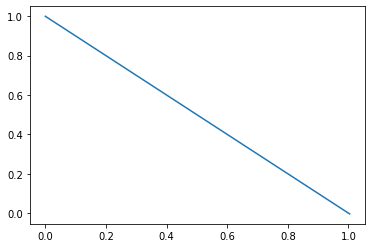

In [14]:
X, Y = simple_contour(h)
plt.plot(X, Y)

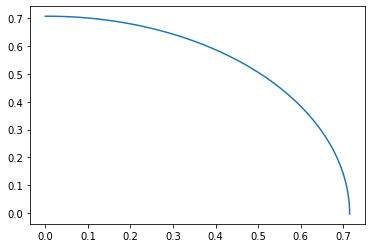

In [13]:
X, Y = simple_contour(f)
plt.plot(X, Y)

Limites de cette méthode :
Le tracé de la ligne de niveau ne peut être réalisé que si le théorème des fonctions implicites s'applique, ie si la ligne de niveau n'admet pas de point singulier.

#### Deuxième méthode

A partir d'un point $(u,v)$ donné de la ligne de niveau $f(x,y) = c$, on construit le point suivant en se décalant sur la tangente de la ligne au point $(u,v)$,, orthogonale au gradient de la fonction étudiée en ce point, d'une distance $\delta$. Cette approximation étant un peu grossière, on affine le résultat en se rapprochant du point suivant "réel" grâce à une méthode de Newton en deux dimension. i.e. on cherche à annuler $F$ où :  
$F : \begin{pmatrix} x \\ y \end{pmatrix} \mapsto \begin{pmatrix} f(x,y)-c \\ \sqrt{(x - u)^2 + (y - v)^2}-\delta \end{pmatrix}$  
La suite donnée par :  
$\begin{pmatrix} x_{n+1} \\ y_{n+1} \end{pmatrix} = \begin{pmatrix} x_n \\ y_n \end{pmatrix} + (J_F(x_n,y_n))^{-1} F(x_n,y_n)$,  
où $J_F(x_n,y_n)$ désigne la matrice jacobienne de $F$ en $(x_n,y_n)$, converge vers le point de la ligne de niveau situé à une distance $\delta$ de $(x,y)$.

In [15]:
def grad_f(f, x, y) :
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]  

def tangente(f, x, y) :
    T=grad_f(f, x, y)
    a,b = T[0],T[1]
    return np.array([b, -a])

def F(f, x, y, xs, ys, c, delta) :
    dx =xs-x
    dy=ys-y
    s=np.sqrt(dx**2 + dy**2)-delta
    return np.array([f(xs, ys)-c, s])
# F est la fonction qu'on cherche à annuler par méthode de Newton en 2D

def J(f, x, y, xs, ys, c, delta) :
    J = np.zeros(4)
    J = J.reshape(2,2)
    def F1(xs, ys) :
        return F(f,x,y,xs,ys,c,delta)[0]
    def F2(xs, ys) :
        return F(f,x,y,xs,ys,c,delta)[1]
    J[0] = grad_f(F1, xs, ys)
    J[1] = grad_f(F2, xs, ys) 
    return(J) 
# calcul de la jacobienne de F en
# nous n'avons pas réussi à faire fonctionner autograd.jacobian

In [20]:
def point_suivant_deux(f, x ,y, c, delta, eps) :
    T = tangente(f, x, y)
    a, b = T[1], T[0]
    if b < 0 :
        a = -a
        b = -b  # on veut tracer la ligne vers la droite en partant de l'arête de gauche
    xs = x+b*delta/np.sqrt(a**2 + b**2)
    ys = y +a*delta/np.sqrt(a**2 + b**2)
    ecart = 1 + eps
    while ecart > eps  :
        if np.linalg.det(J(f,x,y,xs,ys,c,delta)) != 0 :
            E = -np.dot(np.linalg.inv(J(f, x, y, xs, ys, c, delta)), F(f,x,y,xs,ys,c,delta).reshape(2, 1))
            xs = xs + E[0]
            ys = ys + E[1]
            ecart = np.linalg.norm(E)
        else :
            break
    return(xs, ys)

Remarque :  
La méthode de Newton ne peut fonctionner que si la jacobienne de la fonction $F$ définie plus haut est inversible. Dans le cas contraire, on arrête l'algorithme, quitte à avoir une moins bonne précision (on n'est pas sûr d'être exactement sur la ligne de niveau).

In [21]:
def simple_contour_deux(f, c = 0.0, delta = 0.01, eps = 2**(-26)) :
    t = find_seed(f, c)
    if t != None :
        abscisse = [0.0]
        ordonnee = [t]
        while abscisse[-1] <= 1 and 0 <= ordonnee[-1] <= 1 :
            x, y = point_suivant_deux(f, abscisse[-1], ordonnee[-1], c, delta, eps)
            abscisse.append(x)
            ordonnee.append(y)
        return abscisse, ordonnee
    else :
        return [], []
    
#tracé de la ligne de niveau avec la deuxième méthode

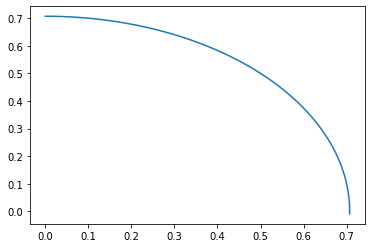

In [22]:
X, Y = simple_contour_deux(f)
plt.plot(X, Y)

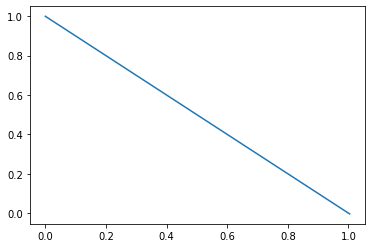

In [23]:
X, Y = simple_contour_deux(h)
plt.plot(X, Y)